In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt


# Setup device-agnostic code
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

'1.12.1+cu113'

# **Data**

In [ ]:
# Create data
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = 0.7 * X + 0.3

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

# **Model**


In [ ]:
# Set the manual seed when creating the model (this isn't always need, try commenting it out and seeing what happens)
torch.manual_seed(42) # You can also set the random seed on the GPU (CUDA devices). torch.cuda.manual_seed(42)

##### M1 : Creating Model in Pytorch from scratch

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [ ]:
model_0 = LinearRegressionModel()

##### M2 : Creating Model using Pytorch Functions

In [ ]:
# Subclass nn.Module to make our model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [ ]:
model_0 = LinearRegressionModel()

##### Model 3 : Creating Model using Sequential Module of Pytorch

In [ ]:
model_0 = torch.nn.Sequential(nn.Linear(in_features=1,out_features=1))

# **Training**



In [ ]:
# Sending model to GPU / CPU whatever is available
model_0 = model_0.to(device)
print(model_0, model_0.state_dict())

In [ ]:
# Sending data on the available device : Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [ ]:
# Create the loss function
loss_fn = nn.MSELoss() # mean squared error loss
loss_fn = nn.L1Loss() # L1Loss

In [ ]:
# Create the optimizer
optimizer = torch.optim.SGD(lr=0.01, params=model_0.parameters())
optimizer = torch.optim.Adam(lr=0.001, params=model_0.parameters())

In [ ]:
# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    ''' Training'''
    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer because during forward pass you dont need this
    optimizer.zero_grad()

    # 4. Loss backwards, now perform backward pass
    loss.backward()

    # 5. Progress the optimizer to update the parameters wrt gradients calculated by loss.backward
    optimizer.step()




    ''' Testing'''
    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # no need of backward pass during testing

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


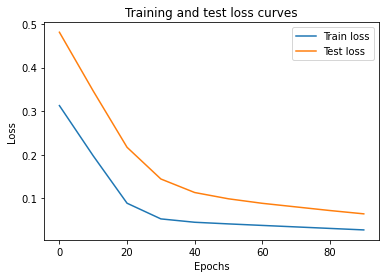

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# **Inference**


In [ ]:
# Set the model in evaluation mode, not necessary but sometimes makes computation faster by skipping unnecessary calcuations behind the scenes
model_0.eval()

# Setup the inference mode context manager, not necessary but sometimes makes computation faster by skipping unnecessary calcuations (like gradient tracking, ...) behind the scenes which were necessary for training but not for testing
# In old PyTorch, you may also see `torch.no_grad()` being used for inference. While `torch.inference_mode()` and `torch.no_grad()` do similar things, `torch.inference_mode()` is newer, potentially faster and preferred.
with torch.inference_mode():

  # send data and model to available device
  model_0.to(device)
  X_test = X_test.to(device)

  # perform prediction
  y_preds = model_0(X_test)

print(y_preds)

# **Saving and loading**


In [ ]:
from pathlib import Path

# 1. Create models directory for saving models
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path, model will be saved like this
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
'''Now performing predictions using the loaded model'''

# Put the loaded model to the target device
loaded_model_0.to(device)

# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model